### grp

# Course: _Feature Engineering with PySpark_:
1.  eda
2.  functions
3.  fe
4.  ml pipelines

https://spark.apache.org/docs/latest/api/python/index.html

## _1. Exploratory Data Analysis_:
1. Project Scoping / Data Collection
2. Exploratory Analysis
3. Data Cleaning
4. Feature Engineering
5. Model Training
6. Project Delivery / Insights

-  EDA functions:
    -  ```pyspark.sql.functions.mean(col)```
    -  ```pyspark.sql.functions.skewness(col)```
    -  ```pyspark.sql.functions.min(col)```
    -  ```cov(col1, col2)``` 
    -  ```corr(col1, col2)```
    -  ```sample(withReplacement, fraction, seed=None)```

#### versions

In [1]:
print(spark.version)
import sys
print(sys.version_info)

2.4.3
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


#### libs

In [2]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Row
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### read

In [3]:
PATH = "course_data/spark_fe/2017_StPaul_MN_Real_Estate.csv"
df = spark.read.csv(PATH, header=True, inferSchema=True)

In [4]:
def cleanCols(df):
    l = df.columns
    cols = [c.replace(' ','_').
              replace('[.]','_').
              replace('.','_').
              replace('[[:punct:]]','_').
              lower() for c in l]
    return df.toDF(*cols)
df = cleanCols(df)

In [5]:
for i in df.columns:
    df = df.withColumnRenamed(i, i.upper()) # upper all cols

#### examine dv

In [6]:
Y_df = df.select('SALESCLOSEPRICE')
Y_df.describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



#### verify data load

In [7]:
def check_load(df, num_records, num_columns):
  # Takes a dataframe and compares record and column counts to input
  # Message to return if the critera below aren't met
  message = 'Validation Failed'
  # Check number of records
  if num_records == df.count():
    # Check number of columns
    if num_columns == len(df.columns):
      # Success message
      message = 'Validation Passed'
  return message

print(check_load(df, 5000, 74))

Validation Passed


#### verify data types

In [8]:
validation_dict = {'ASSESSMENTPENDING': 'string',
 'ASSESSEDVALUATION': 'double',
 'ASSOCIATIONFEE': 'int',
 'ASSUMABLEMORTGAGE': 'string',
 'SQFTBELOWGROUND': 'int'}

In [9]:
# Create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)
print("="*10)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict:

    # Compare attribute names and types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

[('NO_', 'int'), ('MLSID', 'string'), ('STREETNUMBERNUMERIC', 'int'), ('STREETADDRESS', 'string'), ('STREETNAME', 'string'), ('POSTALCODE', 'int'), ('STATEORPROVINCE', 'string'), ('CITY', 'string'), ('SALESCLOSEPRICE', 'int'), ('LISTDATE', 'string'), ('LISTPRICE', 'int'), ('LISTTYPE', 'string'), ('ORIGINALLISTPRICE', 'int'), ('PRICEPERTSFT', 'double'), ('FOUNDATIONSIZE', 'int'), ('FENCE', 'string'), ('MAPLETTER', 'string'), ('LOTSIZEDIMENSIONS', 'string'), ('SCHOOLDISTRICTNUMBER', 'string'), ('DAYSONMARKET', 'int'), ('OFFMARKETDATE', 'string'), ('FIREPLACES', 'int'), ('ROOMAREA4', 'string'), ('ROOMTYPE', 'string'), ('ROOF', 'string'), ('ROOMFLOOR4', 'string'), ('POTENTIALSHORTSALE', 'string'), ('POOLDESCRIPTION', 'string'), ('PDOM', 'int'), ('GARAGEDESCRIPTION', 'string'), ('SQFTABOVEGROUND', 'int'), ('TAXES', 'int'), ('ROOMFLOOR1', 'string'), ('ROOMAREA1', 'string'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'int'), ('LIVINGAREA', 'int'), ('UNITNUMBER', 'string'), ('YEARBUILT', 'i

#### correlation

In [10]:
columns = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'FIREPLACES',
 'PDOM',
 'SQFTABOVEGROUND',
 'TAXES',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LIVINGAREA',
 'YEARBUILT',
 'ACRES',
 'BATHSFULL',
 'BATHSHALF',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BEDROOMS',
 'SQFTBELOWGROUND',
 'ASSOCIATIONFEE',
 'ASSESSEDVALUATION']

In [11]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr('SALESCLOSEPRICE', col)
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


#### visualize

[Row(skewness(LISTPRICE)=2.790448093916559)]


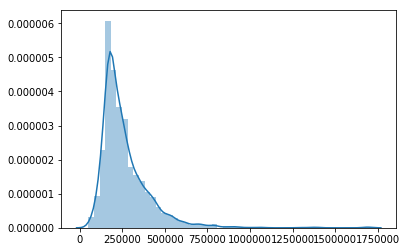

In [13]:
# Sample
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

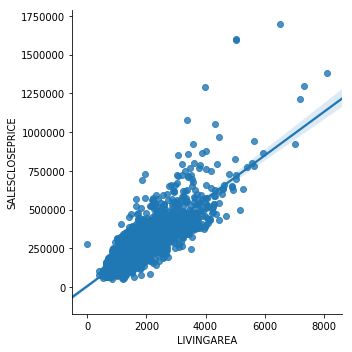

In [14]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)

## _2. Wrangling with Spark Functions_:
- Bad Data Topics:
    -  incorrect format
    -  duplications
    -  missing
    -  irrelevant
    -  recorded wrong
- Functions:
    -  ```drop(*cols)```
    -  ```where(condition)```
    -  ```like(other)```
    -  ```~``` => NOT condition
    -  ```dropna(...)```
    -  ```fillna(...)```
    -  ```dropDuplicates()```
-  MinMaxScaling:
    -  scale each feature between 0 and 1
-  Standardization:
    -  transform data to standard normal distribution
    -  mean of 0 and standard deviation of 1
-  Log Scaling:
    -  scales skewed data distributions
-  Joins:
    -  inner join
    -  left join
    -  right join
    -  full join

#### drop specific cols

In [15]:
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']
df = df.drop(*cols_to_drop)

#### text filters

In [16]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE']\
.isin(yes_values) | df['ASSUMABLEMORTGAGE']\
.isNull() # keep nulls
df = df.where(text_filter)

# print count of remaining records
print(df.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

4976


In [17]:
df.select("ASSUMABLEMORTGAGE").distinct().show()

+------------------+
| ASSUMABLEMORTGAGE|
+------------------+
|Information Coming|
|              null|
|     Not Assumable|
+------------------+



#### remove outliers

In [18]:
schema = T.StructType([T.StructField('log_SalesClosePrice', T.FloatType())])

In [19]:
scaled_DF = spark\
.createDataFrame\
([Row(log_SalesClosePrice=11.870599909242044),
  Row(log_SalesClosePrice=12.154779351142624),
  Row(log_SalesClosePrice=12.323855681186558),
  Row(log_SalesClosePrice=12.487485104968359),
  Row(log_SalesClosePrice=12.428816116823043),
  Row(log_SalesClosePrice=12.449018824140563),
  Row(log_SalesClosePrice=12.421184025147118),
  Row(log_SalesClosePrice=12.409013489526863),
  Row(log_SalesClosePrice=12.448979607685333),
  Row(log_SalesClosePrice=12.429216196844383)], schema=schema)

In [20]:
# Calculate values used for outlier filtering
mean_val = scaled_DF.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = scaled_DF.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]
print(mean_val)
print(stddev_val)

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
scaled_DF = scaled_DF\
.where((scaled_DF['log_SalesClosePrice'] < hi_bound)\
       & (scaled_DF['log_SalesClosePrice'] > low_bound))

12.342294692993164
0.19077796152944548


#### manual scaling

In [21]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]
print(max_days)
print(min_days)

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                  F.round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

225
0
[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


#### function scaling

In [22]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

In [23]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df
  
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



#### skewed features

In [24]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / F.log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25060307835912676)]


#### visualize missing data

In [25]:
columns = ['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

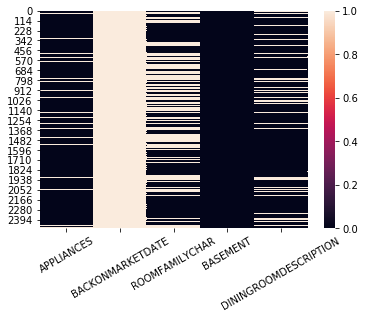

In [26]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

#### imputing missing data

In [27]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df = df.fillna(col_mean, subset=['PDOM'])

#### drop missing cols function

In [28]:
len(df.columns)

78

In [29]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[col].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

In [30]:
len(df.columns)

72

#### joins

In [31]:
walk_schema = T.StructType([T.StructField('latitude', T.DoubleType()),\
                     T.StructField('longitude', T.DoubleType()),\
                     T.StructField('walkscore', T.IntegerType()),\
                     T.StructField('bikescore', T.IntegerType()),\
                     T.StructField('transitscore',T.IntegerType())])

round_schema = T.StructType([T.StructField('latitude', T.DoubleType()),\
                     T.StructField('longitude', T.DoubleType())])

In [32]:
walk_df = spark\
.createDataFrame\
([Row(latitude=45.00585, longitude=-92.87286, walkscore=61, bikescore=72, transitscore=None),
  Row(latitude=44.9581, longitude=-93.17982, walkscore=74, bikescore=83, transitscore=None),
  Row(latitude=44.93788, longitude=-93.12767, walkscore=84, bikescore=73, transitscore=None),
  Row(latitude=44.95359, longitude=-93.09431, walkscore=48, bikescore=60, transitscore=None),
  Row(latitude=44.97547, longitude=-92.93275, walkscore=83, bikescore=53, transitscore=None),
  Row(latitude=44.98683, longitude=-93.03703, walkscore=37, bikescore=48, transitscore=None),
  Row(latitude=44.97599, longitude=-93.0087, walkscore=6, bikescore=48, transitscore=None),
  Row(latitude=44.9536, longitude=-92.9059, walkscore=30, bikescore=None, transitscore=None),
  Row(latitude=44.89481, longitude=-92.93275, walkscore=4, bikescore=None, transitscore=None),
  Row(latitude=44.97947, longitude=-93.1949, walkscore=71, bikescore=76, transitscore=None)], schema=walk_schema)

round_df = spark\
.createDataFrame\
([Row(latitude=45.005846, longitude=-92.872856),
 Row(latitude=44.994875, longitude=-92.879271),
 Row(latitude=44.99224807, longitude=-92.9327565),
 Row(latitude=44.9948004, longitude=-92.8779735),
 Row(latitude=44.99087303, longitude=-92.93379917),
 Row(latitude=45.00314641, longitude=-92.87810291),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957)], schema=round_schema)

In [33]:
# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# Round percision
round_df = round_df.withColumn('longitude', F.round(round_df['longitude'], 5))
round_df = round_df.withColumn('latitude', F.round(round_df['latitude'], 5))

# Create join condition
condition = [(round_df['longitude'] == walk_df['longitude']),\
             (round_df['latitude'] == walk_df['latitude'])]

# Join the dataframes together
join_df = round_df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())
join_df.show()

5
+--------+---------+--------+---------+---------+---------+------------+
|latitude|longitude|latitude|longitude|walkscore|bikescore|transitscore|
+--------+---------+--------+---------+---------+---------+------------+
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
|45.00585|-92.87286|45.00585|-92.87286|       61|       72|        null|
|44.99087| -92.9338|    null|     null|     null|     null|        null|
|44.99225|-92.93276|    null|     null|     null|     null|        null|
| 44.9948|-92.87797|    null|     null|     null|     null|        null|
|45.00315| -92.8781|    null|     null|     null|     null|        null|
|44.99488|-92.87927|    null|     null|     null|     null|        null|
+--------+---------+--------+---------+---------+

#### spark sql join

In [34]:
# Register dataframes as tables
walk_df.createOrReplaceTempView("walk_df")
round_df.createOrReplaceTempView("round_df")

# SQL to join dataframes
join_sql = \
"""
SELECT *
FROM round_df
LEFT JOIN walk_df
ON round_df.longitude = walk_df.longitude
AND round_df.latitude = walk_df.latitude
"""
# Perform sql join
joined_df = spark.sql(join_sql)

In [35]:
joined_df.show()

+--------+---------+--------+---------+---------+---------+------------+
|latitude|longitude|latitude|longitude|walkscore|bikescore|transitscore|
+--------+---------+--------+---------+---------+---------+------------+
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
| 44.9536| -92.9059| 44.9536| -92.9059|       30|     null|        null|
|45.00585|-92.87286|45.00585|-92.87286|       61|       72|        null|
|44.99087| -92.9338|    null|     null|     null|     null|        null|
|44.99225|-92.93276|    null|     null|     null|     null|        null|
| 44.9948|-92.87797|    null|     null|     null|     null|        null|
|45.00315| -92.8781|    null|     null|     null|     null|        null|
|44.99488|-92.87927|    null|     null|     null|     null|        null|
+--------+---------+--------+---------+---------+--

#### bad join

In [36]:
walk_df = spark\
.createDataFrame\
([Row(latitude=45.00585, longitude=-92.87286, walkscore=61, bikescore=72, transitscore=None),
  Row(latitude=44.9581, longitude=-93.17982, walkscore=74, bikescore=83, transitscore=None),
  Row(latitude=44.93788, longitude=-93.12767, walkscore=84, bikescore=73, transitscore=None),
  Row(latitude=44.95359, longitude=-93.09431, walkscore=48, bikescore=60, transitscore=None),
  Row(latitude=44.97547, longitude=-92.93275, walkscore=83, bikescore=53, transitscore=None),
  Row(latitude=44.98683, longitude=-93.03703, walkscore=37, bikescore=48, transitscore=None),
  Row(latitude=44.97599, longitude=-93.0087, walkscore=6, bikescore=48, transitscore=None),
  Row(latitude=44.9536, longitude=-92.9059, walkscore=30, bikescore=None, transitscore=None),
  Row(latitude=44.89481, longitude=-92.93275, walkscore=4, bikescore=None, transitscore=None),
  Row(latitude=44.97947, longitude=-93.1949, walkscore=71, bikescore=76, transitscore=None)], schema=walk_schema)

round_df = spark\
.createDataFrame\
([Row(latitude=45.005846, longitude=-92.872856),
 Row(latitude=44.994875, longitude=-92.879271),
 Row(latitude=44.99224807, longitude=-92.9327565),
 Row(latitude=44.9948004, longitude=-92.8779735),
 Row(latitude=44.99087303, longitude=-92.93379917),
 Row(latitude=45.00314641, longitude=-92.87810291),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957),
 Row(latitude=44.953597, longitude=-92.9058957)], schema=round_schema)

In [37]:
# Join on mismatched keys precision 
wrong_prec_cond = [round_df['longitude'] == walk_df['longitude'], round_df['latitude'] == walk_df['latitude']]
wrong_prec_df = round_df.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(joined_df.where(joined_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [round_df['longitude'] == walk_df['longitude']]
few_keys_df = round_df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(joined_df.count()))

10
5
Record Count of the Too Few Keys Join Example: 10
Record Count of the Correct Join Example: 10


## _3. Feature Engineering_:
-  New Feature Generation Techniques:
    -  multiplying
    -  summing
    -  differencing
    -  dividing
    -  splitting
    -  exploding
    -  joining
    -  binarizing
    -  bucketing
    -  encoding

#### feature difference

In [38]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.22108574372162215
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6164840497949827
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20760999605939529


#### feature ratio

In [39]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSED_TO_LIST', 'ASSESSEDVALUATION', 'LISTPRICE']].show(5)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+----------------+-----------------+---------+
|ASSESSED_TO_LIST|ASSESSEDVALUATION|LISTPRICE|
+----------------+-----------------+---------+
|             0.0|              0.0|   139900|
|             0.0|              0.0|   210000|
|             0.0|              0.0|   225000|
|             0.0|              0.0|   230000|
|             0.0|              0.0|   239900|
+----------------+-----------------+---------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.333333333

#### multi feature combination

In [40]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               4976|
|   mean| 1.4315755045931757|
| stddev| 14.162914660169035|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



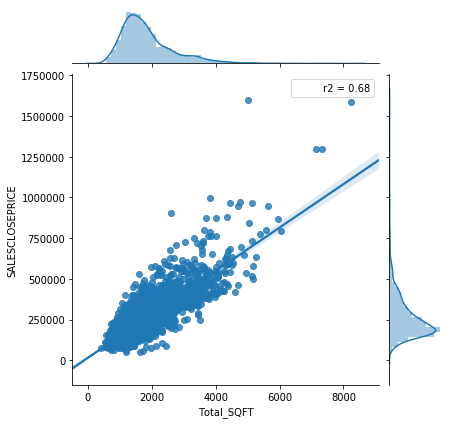

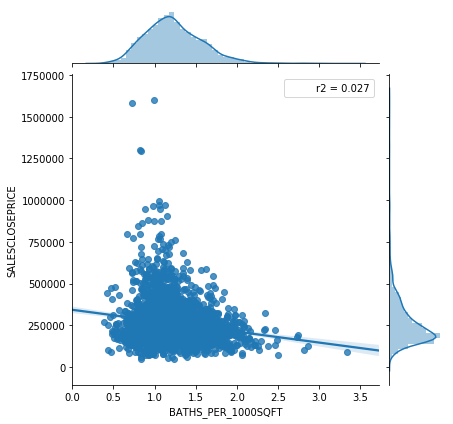

In [49]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)

#### time

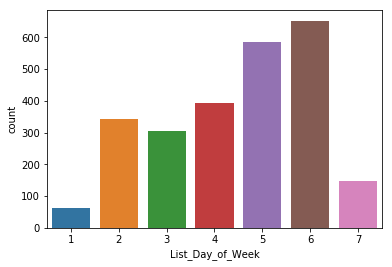

In [44]:
# Convert to date type
df = df\
.withColumn('LISTDATE',\
            F.to_timestamp(F.from_unixtime(F.unix_timestamp(F.col('LISTDATE'), 'MM/dd/yyyy HH:mm'),\
                            'yyyy-MM-dd HH:mm:ss')))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', F.dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)

#### join on time

In [46]:
price_schema = T.StructType([T.StructField('City_', T.StringType()),\
                             T.StructField('MedianHomeValue', T.StringType()),\
                             T.StructField('Year', T.StringType())])

In [47]:
price_df = spark\
.createDataFrame\
([Row(City_='LELM - Lake Elmo', MedianHomeValue='401000', Year='2016'),
  Row(City_='MAPW - Maplewood', MedianHomeValue='193000', Year='2016'),
  Row(City_='STP - Saint Paul', MedianHomeValue='172000', Year='2016'),
  Row(City_='WB - Woodbury', MedianHomeValue='291000', Year='2016'),
  Row(City_='OAKD - Oakdale', MedianHomeValue='210000', Year='2016'),
  Row(City_='LELM - Lake Elmo', MedianHomeValue='385000', Year='2015'),
  Row(City_='MAPW - Maplewood', MedianHomeValue='187000', Year='2015'),
  Row(City_='STP - Saint Paul', MedianHomeValue='162000', Year='2015'),
  Row(City_='WB - Woodbury', MedianHomeValue='277000', Year='2015'),
  Row(City_='OAKD - Oakdale', MedianHomeValue='192000', Year='2015')], schema=price_schema)

In [48]:
# Create year column
df = df.withColumn('list_year', F.year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

# Create join condition
condition = [df['CITY'] == price_df['City_'], df['report_year'] == price_df['Year']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')
# Inspect that new columns are available
df[['MedianHomeValue']].show()

+---------------+
|MedianHomeValue|
+---------------+
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
|         210000|
+---------------+
only showing top 20 rows



#### window / lag function

In [50]:
window_schema = T.StructType([T.StructField('DATE', T.StringType()),\
                             T.StructField('MORTGAGE30US', T.StringType())])

In [51]:
mort_df = spark\
.createDataFrame\
([Row(DATE='2013-10-10', MORTGAGE30US='4.23'),
  Row(DATE='2013-10-17', MORTGAGE30US='4.28'),
  Row(DATE='2013-10-24', MORTGAGE30US='4.13'),
  Row(DATE='2013-10-31', MORTGAGE30US='4.10'),
  Row(DATE='2013-11-07', MORTGAGE30US='4.16'),
  Row(DATE='2013-11-14', MORTGAGE30US='4.35'),
  Row(DATE='2013-11-21', MORTGAGE30US='4.22'),
  Row(DATE='2013-11-27', MORTGAGE30US='4.29'),
  Row(DATE='2013-12-05', MORTGAGE30US='4.46'),
  Row(DATE='2013-12-12', MORTGAGE30US='4.42')], schema=window_schema)

In [52]:
# Cast data type
mort_df = mort_df.withColumn('DATE', F.to_date('DATE'))

# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df.withColumn('DATE-1', F.lag('DATE', count=1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', F.datediff('DATE', 'DATE-1'))
# Print results
mort_df.select('Days_Between_Report').distinct().show()

+-------------------+
|Days_Between_Report|
+-------------------+
|               null|
|                  7|
|                  6|
|                  8|
+-------------------+



In [53]:
mort_df.printSchema()

root
 |-- DATE: date (nullable = true)
 |-- MORTGAGE30US: string (nullable = true)
 |-- DATE-1: date (nullable = true)
 |-- Days_Between_Report: integer (nullable = true)



In [54]:
mort_df.show(truncate=False)

+----------+------------+----------+-------------------+
|DATE      |MORTGAGE30US|DATE-1    |Days_Between_Report|
+----------+------------+----------+-------------------+
|2013-10-10|4.23        |null      |null               |
|2013-10-17|4.28        |2013-10-10|7                  |
|2013-10-24|4.13        |2013-10-17|7                  |
|2013-10-31|4.10        |2013-10-24|7                  |
|2013-11-07|4.16        |2013-10-31|7                  |
|2013-11-14|4.35        |2013-11-07|7                  |
|2013-11-21|4.22        |2013-11-14|7                  |
|2013-11-27|4.29        |2013-11-21|6                  |
|2013-12-05|4.46        |2013-11-27|8                  |
|2013-12-12|4.42        |2013-12-05|7                  |
+----------+------------+----------+-------------------+



#### extract text to new features

In [55]:
# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', F.when(has_attached_garage, 1)\
                   .when(has_detached_garage, 0)\
                   .otherwise(None))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+--------------------------------------------------------------------------------------------+-------------------+
|                                                                           GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------------------------------------+-------------------+
|                                                                          Driveway - Asphalt|               null|
|                                                 Uncovered/Open, More Parking Onsite for Fee|               null|
|                                                                                   Tuckunder|               null|
|                                                                  Attached Garage, Tuckunder|                  1|
|                                                                             Attached Garage|                  1|
|                                                         Attached Garage, Garag

In [56]:
# spark sql method
df.createOrReplaceTempView("sql_view")

spark.sql("""
SELECT 
    GARAGEDESCRIPTION,
CASE 
    WHEN GARAGEDESCRIPTION like '%Attached Garage%' THEN 1
    WHEN GARAGEDESCRIPTION like '%Detached Garage%' THEN 0
    ELSE null END AS has_attached_garage
FROM
    sql_view
""").show(truncate=False)

+--------------------------------------------------------------------------------------------+-------------------+
|GARAGEDESCRIPTION                                                                           |has_attached_garage|
+--------------------------------------------------------------------------------------------+-------------------+
|Driveway - Asphalt                                                                          |null               |
|Uncovered/Open, More Parking Onsite for Fee                                                 |null               |
|Tuckunder                                                                                   |null               |
|Attached Garage, Tuckunder                                                                  |1                  |
|Attached Garage                                                                             |1                  |
|Attached Garage, Garage Door Opener                                            

#### split / explode

In [57]:
# Convert string to list-like array
df = df.withColumn('garage_list', F.split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', F.explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(truncate=False)

+----------------------------+
|ex_garage_list              |
+----------------------------+
|Attached Garage             |
|On-Street Parking Only      |
|None                        |
|More Parking Onsite for Fee |
|Garage Door Opener          |
|No Int Access to Dwelling   |
|Driveway - Gravel           |
|Valet Parking for Fee       |
|Uncovered/Open              |
|Heated Garage               |
|Underground Garage          |
|Other                       |
|Unassigned                  |
|More Parking Offsite for Fee|
|Driveway - Other Surface    |
|Contract Pkg Required       |
|Carport                     |
|Secured                     |
|Detached Garage             |
|Driveway - Asphalt          |
+----------------------------+
only showing top 20 rows



In [58]:
# org cols
df.select("GARAGEDESCRIPTION", "garage_list").show()

+--------------------+--------------------+
|   GARAGEDESCRIPTION|         garage_list|
+--------------------+--------------------+
|  Driveway - Asphalt|[Driveway - Asphalt]|
|Uncovered/Open, M...|[Uncovered/Open, ...|
|           Tuckunder|         [Tuckunder]|
|Attached Garage, ...|[Attached Garage,...|
|     Attached Garage|   [Attached Garage]|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|     Attached Garage|   [Attached Garage]|
|     Attached Garage|   [Attached Garage]|
|     Attached Garage|   [Attached Garage]|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached Garage,...|
|     Attached Garage|   [Attached Garage]|
|     Attached Garage|   [Attached Garage]|
|Attached Garage, ...|[Attached Garage,...|
|Attached Garage, ...|[Attached 

#### pivot / join

In [59]:
# Lit Constant Value
ex_df = ex_df.withColumn("constant_val", F.lit(1))

# Pivot 
piv_df = ex_df.groupBy('NO_').pivot('ex_garage_list').agg(F.coalesce(F.first('constant_val')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO_', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

In [60]:
piv_df.printSchema()

root
 |-- NO_: integer (nullable = true)
 |-- Assigned: integer (nullable = true)
 |-- Attached Garage: integer (nullable = true)
 |-- Carport: integer (nullable = true)
 |-- Contract Pkg Required: integer (nullable = true)
 |-- Covered: integer (nullable = true)
 |-- Detached Garage: integer (nullable = true)
 |-- Driveway - Asphalt: integer (nullable = true)
 |-- Driveway - Concrete: integer (nullable = true)
 |-- Driveway - Gravel: integer (nullable = true)
 |-- Driveway - Other Surface: integer (nullable = true)
 |-- Driveway - Shared: integer (nullable = true)
 |-- Garage Door Opener: integer (nullable = true)
 |-- Heated Garage: integer (nullable = true)
 |-- Insulated Garage: integer (nullable = true)
 |-- More Parking Offsite for Fee: integer (nullable = true)
 |-- More Parking Onsite for Fee: integer (nullable = true)
 |-- No Int Access to Dwelling: integer (nullable = true)
 |-- None: integer (nullable = true)
 |-- On-Street Parking Only: integer (nullable = true)
 |-- Other:

In [61]:
joined_df.printSchema()

root
 |-- NO_: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- STREETADDRESS: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- POSTALCODE: integer (nullable = true)
 |-- STATEORPROVINCE: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- SALESCLOSEPRICE: integer (nullable = true)
 |-- LISTDATE: timestamp (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- ORIGINALLISTPRICE: integer (nullable = true)
 |-- PRICEPERTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MAPLETTER: string (nullable = true)
 |-- SCHOOLDISTRICTNUMBER: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- OFFMARKETDATE: string (nullable = true)
 |-- FIREPLACES: integer (nullable = true)
 |-- ROOMAREA4: string (nullable = true)
 |-- ROOMTYPE: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- ROOMFLOOR4

#### binarize

In [62]:
# Cast as double
df = df.withColumn("List_Day_of_Week", F.col("List_Day_of_Week").cast("double"))

# Import transformer
from pyspark.ml.feature import Binarizer

# Create the transformer => weekday being 0 and weekend being 1
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             6.0|              1.0|
|             4.0|              0.0|
|             6.0|              1.0|
|             6.0|              1.0|
|             2.0|              0.0|
|             6.0|              1.0|
|             2.0|              0.0|
|             7.0|              1.0|
|             3.0|              0.0|
|             7.0|              1.0|
|             6.0|              1.0|
|             6.0|              1.0|
|             4.0|              0.0|
|             6.0|              1.0|
|             3.0|              0.0|
|             5.0|              0.0|
|             2.0|              0.0|
|             3.0|              0.0|
|             6.0|              1.0|
|             6.0|              1.0|
+----------------+-----------------+
only showing top 20 rows



#### bucket

In [63]:
sample_df = df.select("BEDROOMS").sample(False, 0.5, 42).toPandas()

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     1.0|     1.0|
|     1.0|     1.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     2.0|     2.0|
+--------+--------+
only showing top 20 rows



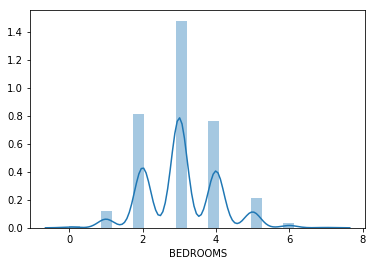

In [64]:
# Import transformer
from pyspark.ml.feature import Bucketizer

# Plot distribution of sample_df
sns.distplot(sample_df, axlabel='BEDROOMS')

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df
df = buck.transform(df)

# Display results
df[['BEDROOMS', 'bedrooms']].show()

#### encode

implementation in PySpark is different than Pandas ```get_dummies()``` as it puts everything into a single column of type vector rather than a new column for each value. It's also different from sklearn's ```OneHotEncoder()``` in that the last categorical value is captured by a vector of all zeros

In [65]:
# Import transformer
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].distinct().show(truncate=False)

+-----------------------------+------------+-------------+
|SCHOOLDISTRICTNUMBER         |School_Index|School_Vec   |
+-----------------------------+------------+-------------+
|625 - St. Paul               |0.0         |(7,[0],[1.0])|
|834 - Stillwater             |3.0         |(7,[3],[1.0])|
|832 - Mahtomedi              |5.0         |(7,[5],[1.0])|
|624 - White Bear Lake        |6.0         |(7,[6],[1.0])|
|6 - South St. Paul           |7.0         |(7,[],[])    |
|622 - North St Paul-Maplewood|1.0         |(7,[1],[1.0])|
|623 - Roseville              |4.0         |(7,[4],[1.0])|
|833 - South Washington County|2.0         |(7,[2],[1.0])|
+-----------------------------+------------+-------------+



## _4. Building a Model_:
-  ```ml.regression```
-  ```ml.classification```
-  ```ml.clustering```
-  ```ml.fpm```
-  ```ml.recommendation```

#### time series train / test split

In [66]:
from datetime import datetime, timedelta

ts_schema = T.StructType([T.StructField('OFFMKTDATE', T.StringType()),\
                          T.StructField('DAYSONMARKET', T.IntegerType()),\
                          T.StructField('LISTDATE', T.StringType())])

In [67]:
ts_df = spark\
.createDataFrame\
([Row(OFFMKTDATE='2017-07-30 00:00:00', DAYSONMARKET=10, LISTDATE='2017-07-15 00:00:00'),
 Row(OFFMKTDATE='2017-10-13 00:00:00', DAYSONMARKET=4, LISTDATE='2017-10-09 00:00:00'),
 Row(OFFMKTDATE='2017-07-24 00:00:00', DAYSONMARKET=28, LISTDATE='2017-06-26 00:00:00'),
 Row(OFFMKTDATE='2017-09-13 00:00:00', DAYSONMARKET=19, LISTDATE='2017-08-25 00:00:00'),
 Row(OFFMKTDATE='2017-10-03 00:00:00', DAYSONMARKET=21, LISTDATE='2017-09-12 00:00:00'),
 Row(OFFMKTDATE='2017-04-27 00:00:00', DAYSONMARKET=17, LISTDATE='2017-04-10 00:00:00'),
 Row(OFFMKTDATE='2017-07-10 00:00:00', DAYSONMARKET=32, LISTDATE='2017-06-08 00:00:00'),
 Row(OFFMKTDATE='2017-11-10 00:00:00', DAYSONMARKET=5, LISTDATE='2017-11-05 00:00:00'),
 Row(OFFMKTDATE='2017-11-11 00:00:00', DAYSONMARKET=23, LISTDATE='2017-10-12 00:00:00'),
 Row(OFFMKTDATE='2017-11-20 00:00:00', DAYSONMARKET=73, LISTDATE='2017-09-02 00:00:00'),
 Row(OFFMKTDATE='2017-08-07 00:00:00', DAYSONMARKET=80, LISTDATE='2017-05-19 00:00:00'),
 Row(OFFMKTDATE='2017-07-29 00:00:00', DAYSONMARKET=79, LISTDATE='2017-05-11 00:00:00'),
 Row(OFFMKTDATE='2018-01-24 00:00:00', DAYSONMARKET=12, LISTDATE='2017-10-06 00:00:00'),
 Row(OFFMKTDATE='2017-06-11 00:00:00', DAYSONMARKET=1, LISTDATE='2017-03-06 00:00:00'),
 Row(OFFMKTDATE='2017-06-05 00:00:00', DAYSONMARKET=18, LISTDATE='2017-05-18 00:00:00'),
 Row(OFFMKTDATE='2017-10-17 00:00:00', DAYSONMARKET=2, LISTDATE='2017-10-15 00:00:00'),
 Row(OFFMKTDATE='2017-09-22 00:00:00', DAYSONMARKET=12, LISTDATE='2017-09-10 00:00:00'),
 Row(OFFMKTDATE='2017-10-16 00:00:00', DAYSONMARKET=45, LISTDATE='2017-09-01 00:00:00'),
 Row(OFFMKTDATE='2017-06-06 00:00:00', DAYSONMARKET=31, LISTDATE='2017-05-06 00:00:00'),
 Row(OFFMKTDATE='2017-08-27 00:00:00', DAYSONMARKET=16, LISTDATE='2017-08-11 00:00:00'),
 Row(OFFMKTDATE='2017-03-06 00:00:00', DAYSONMARKET=3, LISTDATE='2017-03-03 00:00:00'),
 Row(OFFMKTDATE='2017-04-25 00:00:00', DAYSONMARKET=50, LISTDATE='2017-03-06 00:00:00'),
 Row(OFFMKTDATE='2017-09-30 00:00:00', DAYSONMARKET=40, LISTDATE='2017-06-26 00:00:00'),
 Row(OFFMKTDATE='2017-06-12 00:00:00', DAYSONMARKET=6, LISTDATE='2017-05-13 00:00:00'),
 Row(OFFMKTDATE='2017-06-26 00:00:00', DAYSONMARKET=32, LISTDATE='2017-05-12 00:00:00'),
 Row(OFFMKTDATE='2017-07-25 00:00:00', DAYSONMARKET=19, LISTDATE='2017-07-06 00:00:00'),
 Row(OFFMKTDATE='2017-05-12 00:00:00', DAYSONMARKET=8, LISTDATE='2017-05-04 00:00:00'),
 Row(OFFMKTDATE='2017-05-01 00:00:00', DAYSONMARKET=14, LISTDATE='2017-04-17 00:00:00'),
 Row(OFFMKTDATE='2018-01-02 00:00:00', DAYSONMARKET=2, LISTDATE='2017-11-25 00:00:00'),
 Row(OFFMKTDATE='2017-12-15 00:00:00', DAYSONMARKET=29, LISTDATE='2017-10-03 00:00:00'),
 Row(OFFMKTDATE='2017-05-05 00:00:00', DAYSONMARKET=27, LISTDATE='2017-04-08 00:00:00'),
 Row(OFFMKTDATE='2017-07-17 00:00:00', DAYSONMARKET=7, LISTDATE='2017-06-08 00:00:00'),
 Row(OFFMKTDATE='2017-06-19 00:00:00', DAYSONMARKET=18, LISTDATE='2017-06-01 00:00:00'),
 Row(OFFMKTDATE='2017-11-14 00:00:00', DAYSONMARKET=39, LISTDATE='2017-10-06 00:00:00'),
 Row(OFFMKTDATE='2017-10-10 00:00:00', DAYSONMARKET=38, LISTDATE='2017-09-02 00:00:00'),
 Row(OFFMKTDATE='2017-08-03 00:00:00', DAYSONMARKET=8, LISTDATE='2017-07-26 00:00:00'),
 Row(OFFMKTDATE='2017-06-12 00:00:00', DAYSONMARKET=55, LISTDATE='2017-04-17 00:00:00'),
 Row(OFFMKTDATE='2017-07-10 00:00:00', DAYSONMARKET=54, LISTDATE='2017-05-17 00:00:00'),
 Row(OFFMKTDATE='2017-07-13 00:00:00', DAYSONMARKET=59, LISTDATE='2017-05-15 00:00:00'),
 Row(OFFMKTDATE='2018-01-17 00:00:00', DAYSONMARKET=20, LISTDATE='2017-09-09 00:00:00'),
 Row(OFFMKTDATE='2017-07-05 00:00:00', DAYSONMARKET=0, LISTDATE='2017-07-05 00:00:00'),
 Row(OFFMKTDATE='2017-03-14 00:00:00', DAYSONMARKET=6, LISTDATE='2017-03-08 00:00:00'),
 Row(OFFMKTDATE='2017-10-11 00:00:00', DAYSONMARKET=0, LISTDATE='2017-10-11 00:00:00'),
 Row(OFFMKTDATE='2017-09-18 00:00:00', DAYSONMARKET=71, LISTDATE='2017-07-09 00:00:00'),
 Row(OFFMKTDATE='2017-05-25 00:00:00', DAYSONMARKET=14, LISTDATE='2017-05-11 00:00:00'),
 Row(OFFMKTDATE='2017-07-10 00:00:00', DAYSONMARKET=72, LISTDATE='2017-04-29 00:00:00'),
 Row(OFFMKTDATE='2017-10-09 00:00:00', DAYSONMARKET=27, LISTDATE='2017-09-12 00:00:00'),
 Row(OFFMKTDATE='2017-05-09 00:00:00', DAYSONMARKET=26, LISTDATE='2017-04-13 00:00:00'),
 Row(OFFMKTDATE='2017-09-18 00:00:00', DAYSONMARKET=66, LISTDATE='2017-07-14 00:00:00'),
 Row(OFFMKTDATE='2017-12-13 00:00:00', DAYSONMARKET=146, LISTDATE='2017-10-27 00:00:00')], schema=ts_schema)

In [68]:
ts_df = ts_df\
.select(F.col("OFFMKTDATE")\
        .cast("timestamp"),\
        "DAYSONMARKET", F.col("LISTDATE")\
        .cast("timestamp"))

In [69]:
def train_test_split_date(df, split_col, test_days=45):
  """Calculate the date to split test and training sets"""
  # Find how many days our data spans
  max_date = df.agg({split_col: 'max'}).collect()[0][0]
  min_date = df.agg({split_col: 'min'}).collect()[0][0]
  # Subtract an integer number of days from the last date in dataset
  split_date = max_date - timedelta(days=test_days)
  return split_date

# Find the date to use in spitting test and train
split_date = train_test_split_date(ts_df, 'OFFMKTDATE')

# Create Sequential Test and Training Sets
train_df = ts_df.where(ts_df['OFFMKTDATE'] < split_date)
test_df = ts_df.where(ts_df['OFFMKTDATE'] >= split_date).where(ts_df['LISTDATE'] <= split_date)

In [70]:
split_date = F.to_date(F.lit('2017-12-10'))
# Create Sequential Test set
test_df = ts_df.where(ts_df['OFFMKTDATE'] >= split_date).where(ts_df['LISTDATE'] <= split_date)

# Create a copy of DAYSONMARKET to review later
test_df = test_df.withColumn('DAYSONMARKET_Original', test_df['DAYSONMARKET'])

# Recalculate DAYSONMARKET from what we know on our split date
test_df = test_df.withColumn('DAYSONMARKET', F.datediff(split_date, 'LISTDATE'))

# Review the difference
test_df[['LISTDATE', 'OFFMKTDATE', 'DAYSONMARKET_Original', 'DAYSONMARKET']].show()

+-------------------+-------------------+---------------------+------------+
|           LISTDATE|         OFFMKTDATE|DAYSONMARKET_Original|DAYSONMARKET|
+-------------------+-------------------+---------------------+------------+
|2017-10-06 00:00:00|2018-01-24 00:00:00|                   12|          65|
|2017-11-25 00:00:00|2018-01-02 00:00:00|                    2|          15|
|2017-10-03 00:00:00|2017-12-15 00:00:00|                   29|          68|
|2017-09-09 00:00:00|2018-01-17 00:00:00|                   20|          92|
|2017-10-27 00:00:00|2017-12-13 00:00:00|                  146|          44|
+-------------------+-------------------+---------------------+------------+



#### feature engineering => dropping cols w/ low observations

In [71]:
binary_cols = [
 'ASSIGNED',
 'TANDEM',
 'UNCOVERED/OPEN',
 'TUCKUNDER',
 'DRIVEWAY - ASPHALT',
 'HEATED GARAGE',
 'UNDERGROUND GARAGE',
 'DRIVEWAY - SHARED',
 'CONTRACT PKG REQUIRED',
 'GARAGE DOOR OPENER',
 'MORE PARKING OFFSITE FOR FEE',
 'VALET PARKING FOR FEE',
 'OTHER',
 'MORE PARKING ONSITE FOR FEE',
 'GDRIVEWAY - OTHER SURFACE',
 'DETACHED GARAGE',
 'SECURED',
 'CARPORT',
 'DRIVEWAY - CONCRETE',
 'ON-STREET PARKING ONLY',
 'COVERED',
 'INSULATED GARAGE',
 'UNASSIGNED',
 'NONE',
 'DRIVEWAY - GRAVEL',
 'NO INT ACCESS TO DWELLING',
 'UNITS VARY',
 'ATTACHED GARAGE']

binary_cols = [i.lower().title() for i in binary_cols]

In [72]:
cols = zfilled_df.columns[-28:]

In [73]:
zfilled_df = zfilled_df.select(*cols)

In [74]:
zfilled_df.printSchema()

root
 |-- Assigned: integer (nullable = true)
 |-- Attached Garage: integer (nullable = true)
 |-- Carport: integer (nullable = true)
 |-- Contract Pkg Required: integer (nullable = true)
 |-- Covered: integer (nullable = true)
 |-- Detached Garage: integer (nullable = true)
 |-- Driveway - Asphalt: integer (nullable = true)
 |-- Driveway - Concrete: integer (nullable = true)
 |-- Driveway - Gravel: integer (nullable = true)
 |-- Driveway - Other Surface: integer (nullable = true)
 |-- Driveway - Shared: integer (nullable = true)
 |-- Garage Door Opener: integer (nullable = true)
 |-- Heated Garage: integer (nullable = true)
 |-- Insulated Garage: integer (nullable = true)
 |-- More Parking Offsite for Fee: integer (nullable = true)
 |-- More Parking Onsite for Fee: integer (nullable = true)
 |-- No Int Access to Dwelling: integer (nullable = true)
 |-- None: integer (nullable = true)
 |-- On-Street Parking Only: integer (nullable = true)
 |-- Other: integer (nullable = true)
 |-- Secu

In [75]:
obs_threshold = 30
cols_to_remove = list()
# Inspect first 10 binary columns in list
for col in binary_cols[0:10]:
  # Count the number of 1 values in the binary column
  obs_count = zfilled_df.agg({col:'sum'}).collect()[0][0]
  # If less than our observation threshold, remove
  if obs_count <= obs_threshold:
    cols_to_remove.append(col)
    
# Drop columns and print starting and ending dataframe shapes
new_df = zfilled_df.drop(*cols_to_remove)

print('Rows: ' + str(zfilled_df.count()) + ' Columns: ' + str(len(zfilled_df.columns)))
print('Rows: ' + str(new_df.count()) + ' Columns: ' + str(len(new_df.columns)))

Rows: 4976 Columns: 28
Rows: 4976 Columns: 27


#### feature engineering => replace missing values + convert categoricals to numeric index

In [76]:
rf_schema = T.StructType([T.StructField('CITY', T.StringType()),\
                          T.StructField('LISTTYPE', T.StringType()),\
                          T.StructField('SCHOOLDISTRICTNUMBER', T.StringType()),\
                          T.StructField('POTENTIALSHORTSALE', T.StringType()),\
                          T.StructField('STYLE', T.StringType()),\
                          T.StructField('ASSUMABLEMORTGAGE', T.StringType()),\
                          T.StructField('ASSESSMENTPENDING', T.StringType()),\
                          T.StructField('WALKSCORE', T.DoubleType()),\
                          T.StructField('BIKESCORE', T.DoubleType())])

In [77]:
rf_df = spark\
.createDataFrame(\
[Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Unknown', WALKSCORE=25.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) Split Entry (Bi-Level)', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Unknown', WALKSCORE=2.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='622 - North St Paul-Maplewood', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE='Not Assumable', ASSESSMENTPENDING='No', WALKSCORE=25.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Unknown', WALKSCORE=2.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='622 - North St Paul-Maplewood', POTENTIALSHORTSALE='No', STYLE='(SF) Split Entry (Bi-Level)', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=40.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE='Not Assumable', ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Side x Side', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Yes', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=0.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Yes', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=11.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Quad/4 Corners', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=8.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Side x Side', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=8.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(TH) Side x Side', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='No', WALKSCORE=0.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) Split Entry (Bi-Level)', ASSUMABLEMORTGAGE='Not Assumable', ASSESSMENTPENDING='No', WALKSCORE=5.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='834 - Stillwater', POTENTIALSHORTSALE='No', STYLE='(SF) One Story', ASSUMABLEMORTGAGE=None, ASSESSMENTPENDING='Yes', WALKSCORE=1.0, BIKESCORE=None),
 Row(CITY='LELM - Lake Elmo', LISTTYPE='Exclusive Right', SCHOOLDISTRICTNUMBER='622 - North St Paul-Maplewood', POTENTIALSHORTSALE='No', STYLE='(SF) Two Stories', ASSUMABLEMORTGAGE='Not Assumable', ASSESSMENTPENDING='Unknown', WALKSCORE=5.0, BIKESCORE=None)],\
 schema=rf_schema)


In [78]:
categorical_cols = ['CITY',
 'LISTTYPE',
 'SCHOOLDISTRICTNUMBER',
 'POTENTIALSHORTSALE',
 'STYLE',
 'ASSUMABLEMORTGAGE',
 'ASSESSMENTPENDING']

In [79]:
# Import
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Replace missing values
rf_df = rf_df.fillna(-1, subset=['WALKSCORE', 'BIKESCORE'])

# Create list of StringIndexers using list comprehension
indexers = [StringIndexer(inputCol=col, outputCol=col+"_IDX")\
            .setHandleInvalid("keep") for col in categorical_cols]

# Create pipeline of indexers
indexer_pipeline = Pipeline(stages=indexers)
# Fit and Transform the pipeline to the original data
df_indexed = indexer_pipeline.fit(rf_df).transform(rf_df)

# Clean up redundant columns
df_indexed = df_indexed.drop(*categorical_cols)
# Inspect data transformations
for i in df_indexed.dtypes: print(i)

('WALKSCORE', 'double')
('BIKESCORE', 'double')
('CITY_IDX', 'double')
('LISTTYPE_IDX', 'double')
('SCHOOLDISTRICTNUMBER_IDX', 'double')
('POTENTIALSHORTSALE_IDX', 'double')
('STYLE_IDX', 'double')
('ASSUMABLEMORTGAGE_IDX', 'double')
('ASSESSMENTPENDING_IDX', 'double')


#### split / train model

In [80]:
from pyspark.ml.linalg import SparseVector, VectorUDT

sparse_model_rdd = sc\
.parallelize(\
[(SparseVector(135, {0: 139900.0, 1: 139900.0, 2: 980.0, 3: 10.0, 5: 980.0, 6: 1858.0, 7: 1858.0, 8: 980.0, 9: 1950.0, 10: 1.28, 11: 1.0, 12: 1.0, 15: 2.0, 16: 3.0, 20: 2017.0, 21: 7.0, 22: 28.0, 23: 15.0, 24: 196.0, 25: 25.0, 26: -1.0, 27: 4.03, 28: 3.96, 29: 3.88, 30: 3.9, 31: 3.91, 32: 9.8, 33: 22.4, 34: 67.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.2926, 39: 142.7551, 40: 980.0, 41: 0.0133, 42: 1.5, 43: 1.0, 51: -1.0, 52: -1.0, 53: -1.0, 54: -1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 81: 1.0, 89: 1.0, 95: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 123: 1.0, 133: 1.0}), 143000),
 (SparseVector(135, {0: 210000.0, 1: 210000.0, 2: 1144.0, 3: 4.0, 5: 1268.0, 6: 1640.0, 7: 1640.0, 8: 2228.0, 9: 1971.0, 10: 0.32, 11: 1.0, 14: 2.0, 15: 3.0, 16: 4.0, 17: 960.0, 20: 2017.0, 21: 10.0, 22: 41.0, 23: 9.0, 24: 282.0, 25: 2.0, 26: -1.0, 27: 3.91, 28: 3.85, 29: 3.83, 30: 3.83, 31: 3.78, 32: 32.2, 33: 49.0, 34: 18.8, 35: 14.0, 36: 35.8, 37: 14.6, 38: 0.4392, 39: 94.2549, 40: 2228.0, 41: 0.0078, 42: 1.3333, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 89: 1.0, 92: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 124: 1.0, 133: 1.0}), 190000),
 (SparseVector(135, {0: 225000.0, 1: 225000.0, 2: 1102.0, 3: 28.0, 5: 1102.0, 6: 2390.0, 7: 2390.0, 8: 1102.0, 9: 1949.0, 10: 0.822, 11: 1.0, 15: 1.0, 16: 2.0, 20: 2017.0, 21: 6.0, 22: 26.0, 23: 26.0, 24: 177.0, 25: 25.0, 26: -1.0, 27: 3.88, 28: 3.9, 29: 3.91, 30: 3.89, 31: 3.94, 32: 9.8, 33: 22.4, 34: 67.8, 35: 61.7, 36: 2.7, 38: 0.4706, 39: 204.1742, 40: 1102.0, 41: 0.0106, 42: 2.0, 49: 1.0, 51: -1.0, 52: -1.0, 53: -1.0, 54: -1.0, 57: 1.0, 62: 1.0, 68: 1.0, 70: 1.0, 79: 1.0, 89: 1.0, 92: 1.0, 96: 1.0, 100: 1.0, 103: 1.0, 108: 1.0, 110: 1.0, 115: 1.0, 123: 1.0, 131: 1.0, 132: 1.0}), 225000),
 (SparseVector(135, {0: 230000.0, 1: 230000.0, 2: 959.0, 3: 19.0, 4: 1.0, 5: 1284.0, 6: 2146.0, 7: 2146.0, 8: 1632.0, 9: 1960.0, 10: 0.94, 11: 1.0, 12: 1.0, 15: 2.0, 16: 2.0, 17: 348.0, 20: 2017.0, 21: 8.0, 22: 34.0, 23: 25.0, 24: 237.0, 25: 2.0, 26: -1.0, 27: 3.86, 28: 3.89, 29: 3.9, 30: 3.93, 31: 3.92, 32: 9.8, 33: 22.4, 34: 67.8, 35: 61.7, 36: 2.7, 38: 0.4811, 39: 140.9314, 40: 1632.0, 41: 0.0093, 42: 1.0, 49: 1.0, 52: 1.0, 57: 1.0, 62: 1.0, 68: 1.0, 72: 1.0, 78: -1.0, 79: -1.0, 80: -1.0, 81: -1.0, 82: -1.0, 83: -1.0, 89: 1.0, 92: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 123: 1.0, 133: 1.0}), 265000),
 (SparseVector(135, {0: 239900.0, 1: 239900.0, 2: 1026.0, 3: 21.0, 4: 1.0, 5: 1026.0, 6: 2010.0, 7: 2010.0, 8: 2052.0, 9: 1978.0, 11: 1.0, 14: 1.0, 15: 2.0, 16: 3.0, 17: 1026.0, 20: 2017.0, 21: 9.0, 22: 37.0, 23: 12.0, 24: 255.0, 25: 40.0, 26: -1.0, 27: 3.78, 28: 3.78, 29: 3.82, 30: 3.86, 31: 3.89, 32: 32.2, 33: 49.0, 34: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5018, 39: 116.9103, 40: 2052.0, 41: 0.0084, 42: 1.5, 46: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 80: 1.0, 84: 1.0, 92: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 110: 1.0, 115: 1.0, 124: 1.0, 132: 1.0}), 249900),
 (SparseVector(135, {0: 239900.0, 1: 239900.0, 2: 1152.0, 3: 17.0, 4: 1.0, 5: 1397.0, 6: 1491.0, 7: 1494.0, 8: 1397.0, 9: 1965.0, 10: 0.172, 11: 2.0, 15: 2.0, 16: 3.0, 19: 3.0, 20: 2017.0, 21: 4.0, 22: 15.0, 23: 10.0, 24: 100.0, 25: 11.0, 26: -1.0, 27: 4.08, 28: 4.1, 29: 4.14, 30: 4.23, 31: 4.3, 32: 9.8, 33: 22.4, 34: 67.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5018, 39: 171.7251, 40: 1397.0, 41: 0.0062, 42: 1.5, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 73: 1.0, 78: 1.0, 89: 1.0, 92: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 123: 1.0, 131: 1.0, 132: 1.0}), 255000),
 (SparseVector(135, {0: 250000.0, 1: 265000.0, 2: 700.0, 3: 32.0, 5: 1798.0, 6: 2165.0, 7: 2168.0, 8: 1798.0, 9: 2015.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 19: 3.0, 20: 2017.0, 21: 6.0, 22: 23.0, 23: 8.0, 24: 159.0, 25: 11.0, 26: -1.0, 27: 3.89, 28: 3.94, 29: 3.95, 30: 4.02, 31: 4.05, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5229, 39: 139.0434, 40: 1798.0, 41: 0.0087, 42: 1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 91: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 129: 1.0, 134: 1.0}), 248000),
 (SparseVector(135, {0: 254990.0, 1: 273417.0, 2: 1088.0, 3: 5.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 11.0, 22: 44.0, 23: 5.0, 24: 309.0, 25: 11.0, 26: -1.0, 27: 3.94, 28: 3.94, 29: 3.88, 30: 3.91, 31: 3.85, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5333, 39: 147.1379, 40: 1733.0, 42: 1.0, 45: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 245000),
 (SparseVector(135, {0: 254990.0, 1: 273152.0, 2: 1088.0, 3: 23.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 10.0, 22: 41.0, 23: 12.0, 24: 285.0, 25: 11.0, 26: -1.0, 27: 3.91, 28: 3.85, 29: 3.83, 30: 3.83, 31: 3.78, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5333, 39: 147.1379, 40: 1733.0, 42: 1.0, 45: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 254990),
 (SparseVector(135, {0: 255990.0, 1: 273482.0, 2: 1088.0, 3: 73.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 9.0, 22: 35.0, 23: 2.0, 24: 245.0, 25: 11.0, 26: -1.0, 27: 3.82, 28: 3.86, 29: 3.89, 30: 3.9, 31: 3.93, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5354, 39: 147.7149, 40: 1733.0, 42: 1.0, 48: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 250000),
 (SparseVector(135, {0: 259990.0, 1: 267117.0, 2: 1088.0, 3: 80.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 5.0, 22: 20.0, 23: 19.0, 24: 139.0, 25: 11.0, 26: -1.0, 27: 4.02, 28: 4.05, 29: 4.02, 30: 4.03, 31: 3.97, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5438, 39: 150.0231, 40: 1733.0, 42: 1.0, 45: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 254500),
 (SparseVector(135, {0: 259990.0, 1: 268487.0, 2: 1088.0, 3: 79.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 5.0, 22: 19.0, 23: 11.0, 24: 131.0, 25: 11.0, 26: -1.0, 27: 4.05, 28: 4.02, 29: 4.03, 30: 3.97, 31: 4.08, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5438, 39: 150.0231, 40: 1733.0, 42: 1.0, 45: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 253000),
 (SparseVector(135, {0: 259990.0, 1: 268622.0, 2: 1088.0, 3: 12.0, 5: 1733.0, 8: 1733.0, 9: 2017.0, 10: 0.05, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 190.0, 20: 2017.0, 21: 3.0, 22: 10.0, 23: 12.0, 24: 71.0, 25: 11.0, 26: -1.0, 27: 4.21, 28: 4.1, 29: 4.16, 30: 4.15, 31: 4.17, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5438, 39: 150.0231, 40: 1733.0, 42: 1.0, 45: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 257500),
 (SparseVector(135, {0: 269990.0, 1: 279442.0, 2: 1088.0, 3: 1.0, 5: 1763.0, 8: 1763.0, 9: 2016.0, 10: 0.05, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 3.0, 22: 10.0, 23: 6.0, 24: 65.0, 26: -1.0, 27: 4.21, 28: 4.1, 29: 4.16, 30: 4.15, 31: 4.17, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5647, 39: 153.1424, 40: 1763.0, 42: 1.0, 48: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 272990),
 (SparseVector(135, {0: 270000.0, 1: 270000.0, 2: 1844.0, 3: 18.0, 4: 1.0, 5: 1844.0, 6: 2689.0, 7: 2692.0, 8: 1844.0, 9: 1977.0, 10: 1.661, 14: 3.0, 15: 3.0, 16: 2.0, 19: 3.0, 20: 2017.0, 21: 5.0, 22: 20.0, 23: 18.0, 24: 138.0, 25: 11.0, 26: -1.0, 27: 4.02, 28: 4.05, 29: 4.02, 30: 4.03, 31: 3.97, 32: 32.2, 33: 49.0, 34: 18.8, 35: 61.7, 36: 2.7, 38: 0.5647, 39: 146.4208, 40: 1844.0, 41: 0.01, 42: 0.6667, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 57: 1.0, 62: 1.0, 67: 1.0, 73: 1.0, 79: 1.0, 89: 1.0, 95: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 123: 1.0, 134: 1.0}), 290000),
 (SparseVector(135, {0: 274000.0, 1: 274000.0, 2: 1088.0, 3: 2.0, 5: 1763.0, 8: 1763.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 10.0, 22: 41.0, 23: 15.0, 24: 288.0, 25: 11.0, 26: -1.0, 27: 3.91, 28: 3.85, 29: 3.83, 30: 3.83, 31: 3.78, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5731, 39: 155.4169, 40: 1763.0, 42: 1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 274000),
 (SparseVector(135, {0: 274990.0, 1: 289357.0, 2: 1088.0, 3: 12.0, 5: 1763.0, 8: 1763.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 9.0, 22: 36.0, 23: 10.0, 24: 253.0, 25: 11.0, 26: -1.0, 27: 3.78, 28: 3.82, 29: 3.86, 30: 3.89, 31: 3.9, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5752, 39: 155.9784, 40: 1763.0, 42: 1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 274990),
 (SparseVector(135, {0: 284990.0, 1: 288342.0, 2: 1088.0, 3: 45.0, 5: 1763.0, 8: 1763.0, 9: 2017.0, 10: 0.05, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 9.0, 22: 35.0, 23: 1.0, 24: 244.0, 25: 11.0, 26: -1.0, 27: 3.82, 28: 3.86, 29: 3.89, 30: 3.9, 31: 3.93, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.5961, 39: 161.6506, 40: 1763.0, 42: 1.0, 48: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 274000),
 (SparseVector(135, {0: 287452.0, 1: 287452.0, 2: 1088.0, 3: 31.0, 5: 1763.0, 8: 1763.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 5.0, 22: 18.0, 23: 6.0, 24: 126.0, 25: 11.0, 26: -1.0, 27: 4.02, 28: 4.03, 29: 3.97, 30: 4.08, 31: 4.1, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6012, 39: 163.0471, 40: 1763.0, 42: 1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 282000),
 (SparseVector(135, {0: 288492.0, 1: 288492.0, 2: 1088.0, 3: 16.0, 5: 1763.0, 8: 1763.0, 9: 2017.0, 10: 0.05, 11: 1.0, 12: 1.0, 14: 1.0, 15: 3.0, 16: 3.0, 18: 200.0, 20: 2017.0, 21: 8.0, 22: 32.0, 23: 11.0, 24: 223.0, 25: 8.0, 26: -1.0, 27: 3.9, 28: 3.93, 29: 3.92, 30: 3.96, 31: 4.03, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6034, 39: 163.637, 40: 1763.0, 42: 1.0, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 75: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 128: 1.0, 132: 1.0}), 280617),
 (SparseVector(135, {0: 292371.0, 1: 292371.0, 2: 698.0, 3: 3.0, 4: 1.0, 5: 1778.0, 8: 1778.0, 9: 2016.0, 10: 0.04, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 190.0, 20: 2017.0, 21: 3.0, 22: 9.0, 23: 3.0, 24: 62.0, 25: 8.0, 26: -1.0, 27: 4.1, 28: 4.16, 29: 4.15, 30: 4.17, 31: 4.19, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6115, 39: 164.4381, 40: 1778.0, 42: 1.0, 48: 1.0, 52: 1.0, 57: 1.0, 62: 1.0, 68: 1.0, 69: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 97: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 129: 1.0, 132: 1.0}), 289871),
 (SparseVector(135, {0: 292925.0, 1: 291925.0, 2: 698.0, 3: 50.0, 4: 1.0, 5: 1778.0, 8: 1778.0, 9: 2016.0, 10: 0.04, 11: 2.0, 12: 1.0, 15: 3.0, 16: 3.0, 18: 190.0, 20: 2017.0, 21: 3.0, 22: 10.0, 23: 6.0, 24: 65.0, 26: -1.0, 27: 4.21, 28: 4.1, 29: 4.16, 30: 4.15, 31: 4.17, 32: 81.2, 33: 18.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6127, 39: 164.7497, 40: 1778.0, 42: 1.0, 48: 1.0, 52: 1.0, 57: 1.0, 62: 1.0, 68: 1.0, 69: 1.0, 79: 1.0, 90: 1.0, 94: 1.0, 97: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 129: 1.0, 132: 1.0}), 282500),
 (SparseVector(135, {0: 299900.0, 1: 299900.0, 2: 1300.0, 3: 40.0, 4: 2.0, 5: 1324.0, 6: 1974.0, 7: 1974.0, 8: 2424.0, 9: 1967.0, 10: 0.43, 11: 1.0, 14: 2.0, 15: 3.0, 16: 4.0, 17: 1100.0, 19: 1974.0, 20: 2017.0, 21: 6.0, 22: 26.0, 23: 26.0, 24: 177.0, 25: 5.0, 26: -1.0, 27: 3.88, 28: 3.9, 29: 3.91, 30: 3.89, 31: 3.94, 32: 9.8, 33: 22.4, 34: 67.8, 35: 14.0, 36: 35.8, 37: 14.6, 38: 0.6273, 39: 123.7211, 40: 2424.0, 41: 0.0066, 42: 1.3333, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 73: 1.0, 79: 1.0, 84: 1.0, 93: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 124: 1.0, 131: 1.0, 132: 1.0}), 289900),
 (SparseVector(135, {0: 299900.0, 1: 299900.0, 2: 1200.0, 3: 6.0, 4: 2.0, 5: 1380.0, 6: 1878.0, 7: 1878.0, 8: 2016.0, 9: 1960.0, 10: 0.574, 11: 1.0, 12: 1.0, 15: 2.0, 16: 3.0, 17: 636.0, 20: 2017.0, 21: 5.0, 22: 19.0, 23: 13.0, 24: 133.0, 25: 1.0, 26: -1.0, 27: 4.05, 28: 4.02, 29: 4.03, 30: 3.97, 31: 4.08, 32: 9.8, 33: 22.4, 34: 67.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6273, 39: 148.7599, 40: 2016.0, 41: 0.0063, 42: 1.5, 50: 1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 67: 1.0, 72: 1.0, 78: 1.0, 84: 1.0, 92: 1.0, 96: 1.0, 101: 1.0, 103: 1.0, 108: 1.0, 114: 1.0, 115: 1.0, 123: 1.0, 134: 1.0}), 314500),
 (SparseVector(135, {0: 299900.0, 1: 320000.0, 2: 1148.0, 3: 32.0, 4: 1.0, 5: 1850.0, 6: 2333.0, 7: 2336.0, 8: 2450.0, 9: 1964.0, 10: 0.498, 11: 1.0, 12: 1.0, 15: 2.0, 16: 3.0, 17: 600.0, 19: 3.0, 20: 2017.0, 21: 5.0, 22: 19.0, 23: 12.0, 24: 132.0, 25: 5.0, 26: -1.0, 27: 4.05, 28: 4.02, 29: 4.03, 30: 3.97, 31: 4.08, 32: 9.8, 33: 22.4, 34: 67.8, 35: 49.8, 36: 11.9, 37: 2.7, 38: 0.6273, 39: 122.4082, 40: 2450.0, 41: 0.0078, 42: 1.5, 43: -1.0, 44: -1.0, 45: -1.0, 46: -1.0, 47: -1.0, 48: -1.0, 49: -1.0, 50: -1.0, 52: 1.0, 55: -1.0, 56: -1.0, 57: -1.0, 62: 1.0, 68: 1.0, 77: 1.0, 78: 1.0, 89: 1.0, 92: 1.0, 96: 1.0, 102: 1.0, 103: 1.0, 108: 1.0, 110: 1.0, 115: 1.0, 126: 1.0, 131: 1.0, 133: 1.0}), 280000)])

In [81]:
model_schema = T.StructType([T.StructField('features', VectorUDT()),\
                          T.StructField('SALESCLOSEPRICE', T.IntegerType())])

model_df = sparse_model_rdd.toDF(model_schema)

In [82]:
train_df, test_df = model_df.randomSplit([0.90, 0.10], seed=12345)

In [84]:
# Import algs
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor

# Train a Gradient Boosted Trees (GBT) model
gbt = GBTRegressor(featuresCol="features",
                           labelCol="SALESCLOSEPRICE",
                           predictionCol="Prediction_Price",
                           seed=42
                           )

# Train a Random Forest Trees (RF) model
rf = RandomForestRegressor(featuresCol="features",
                           labelCol="SALESCLOSEPRICE",
                           predictionCol="Prediction_Price",
                           seed=42
                           )


# Train models
gbt_model = gbt.fit(train_df)
rf_model = rf.fit(train_df)

# Test models
gbt_preds = gbt_model.transform(test_df)
rf_preds = rf_model.transform(test_df)

#### evaluate model

In [85]:
# Import eval
from pyspark.ml.evaluation import RegressionEvaluator

# Select columns to compute test error
evaluator = RegressionEvaluator(labelCol="SALESCLOSEPRICE", 
                                predictionCol="Prediction_Price")
# Dictionary of model predictions to loop over
models = {'Gradient Boosted Trees': gbt_preds, 'Random Forest Regression': rf_preds}
for key, preds in models.items():
  # Create evaluation metrics
  rmse = evaluator.evaluate(preds, {evaluator.metricName: "rmse"})
  r2 = evaluator.evaluate(preds, {evaluator.metricName: "r2"})

  # Print Model Metrics
  print(key + ' RMSE: ' + str(rmse))
  print(key + ' R^2: ' + str(r2))

Gradient Boosted Trees RMSE: 16869.075365839606
Gradient Boosted Trees R^2: -0.4013426656282486
Random Forest Regression RMSE: 8556.956020439684
Random Forest Regression R^2: 0.6394210352025678


#### feature importances

In [86]:
feature_cols = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'FIREPLACES',
 'SQFTABOVEGROUND',
 'TAXES',
 'TAXWITHASSESSMENTS',
 'LIVINGAREA',
 'YEARBUILT',
 'ACRES',
 'BATHSFULL',
 'BATHSHALF',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BEDROOMS',
 'SQFTBELOWGROUND',
 'ASSOCIATIONFEE',
 'ASSESSEDVALUATION',
 'LIST_YEAR',
 'LIST_MONTH',
 'LIST_WEEKOFYEAR',
 'LIST_DAYOFMONTH',
 'LIST_DAYOFYEAR',
 'WALKSCORE',
 'BIKESCORE',
 'MORTGAGE30US',
 'MORTGAGE30US-1WK',
 'MORTGAGE30US-2WK',
 'MORTGAGE30US-3WK',
 'MORTGAGE30US-4WK',
 'PERCENT_OLDER_AGE_HOMES',
 'PERCENT_SIMILAR_AGE_HOMES',
 'PERCENT_NEWER_AGE_HOMES',
 'PERCENT_BIGGER_SIZE_HOMES',
 'PERCENT_SIMILAR_SIZE_HOMES',
 'PERCENT_SMALLER_SIZE_HOMES',
 'SQFT_TOTAL',
 'BED_TO_BATHS',
 'FENCE_OTHER',
 'FENCE_WIRE',
 'FENCE_PARTIAL',
 'FENCE_CHAINLINK',
 'FENCE_FULL',
 'FENCE_PRIVACY',
 'FENCE_NONE',
 'FENCE_WOOD',
 'ROOF_AGEOVER8YEARS',
 'ROOF_ASPHALTSHINGLES',
 'ROOF_AGE8YEARSORLESS',
 'ROOF_FLAT',
 'POOLDESCRIPTION_SHARED',
 'POOLDESCRIPTION_BELOWGROUND',
 'POOLDESCRIPTION_NONE',
 'GARAGEDESCRIPTION_HEATEDGARAGE',
 'GARAGEDESCRIPTION_TUCKUNDER',
 'GARAGEDESCRIPTION_UNCOVERED/OPEN',
 'GARAGEDESCRIPTION_OTHER',
 'GARAGEDESCRIPTION_ATTACHEDGARAGE',
 'GARAGEDESCRIPTION_DRIVEWAY-ASPHALT',
 'GARAGEDESCRIPTION_DETACHEDGARAGE',
 'GARAGEDESCRIPTION_NONE',
 'GARAGEDESCRIPTION_UNDERGROUNDGARAGE',
 'APPLIANCES_COOKTOP',
 'APPLIANCES_RANGE',
 'EXTERIOR_BRICK/STONE',
 'EXTERIOR_CEMENTBOARD',
 'EXTERIOR_OTHER',
 'EXTERIOR_STUCCO',
 'EXTERIOR_METAL',
 'EXTERIOR_FIBERBOARD',
 'EXTERIOR_SHAKES',
 'EXTERIOR_WOOD',
 'EXTERIOR_VINYL',
 'DININGROOMDESCRIPTION_SEPARATE/FORMALDININGROOM',
 'DININGROOMDESCRIPTION_INFORMALDININGROOM',
 'DININGROOMDESCRIPTION_BREAKFASTAREA',
 'DININGROOMDESCRIPTION_EATINKITCHEN',
 'DININGROOMDESCRIPTION_LIVING/DININGROOM',
 'DININGROOMDESCRIPTION_KITCHEN/DININGROOM',
 'BASEMENT_WALKOUT',
 'BASEMENT_CRAWLSPACE',
 'BASEMENT_PARTIALFINISHED',
 'BASEMENT_PARTIAL',
 'BASEMENT_UNFINISHED',
 'BASEMENT_FULL',
 'BASEMENT_NONE',
 'BASEMENT_SLAB',
 'BATHDESC_MAINFLOORFULLBATH',
 'BATHDESC_UPPERLEVELFULLBATH',
 'BATHDESC_MAINFLOOR1/2BATH',
 'BATHDESC_MAINFLOOR3/4BATH',
 'ZONING_RESIDENTIAL-SINGLE',
 'ZONING_RESIDENTIAL-MULTI-FAMILY',
 'COOLINGDESCRIPTION_WALL',
 'COOLINGDESCRIPTION_DUCTLESSMINI-SPLIT',
 'COOLINGDESCRIPTION_WINDOW',
 'COOLINGDESCRIPTION_CENTRAL',
 'COOLINGDESCRIPTION_NONE',
 'CITY_LELM-LAKEELMO',
 'CITY_MAPW-MAPLEWOOD',
 'CITY_OAKD-OAKDALE',
 'CITY_STP-SAINTPAUL',
 'CITY_WB-WOODBURY',
 'LISTTYPE_EXCLUSIVERIGHT',
 'LISTTYPE_SERVICEAGREEMENT',
 'SCHOOLDISTRICTNUMBER_622-NORTHSTPAUL-MAPLEWOOD',
 'SCHOOLDISTRICTNUMBER_623-ROSEVILLE',
 'SCHOOLDISTRICTNUMBER_625-STPAUL',
 'SCHOOLDISTRICTNUMBER_833-SOUTHWASHINGTONCOUNTY',
 'SCHOOLDISTRICTNUMBER_834-STILLWATER',
 'POTENTIALSHORTSALE_NO',
 'STYLE_CCHIGHRISE4+LEVELS',
 'STYLE_CCLOWRISE3-LEVELS',
 'STYLE_CCMANOR/VILLAGE',
 'STYLE_SFFOURORMORELEVELSPLIT',
 'STYLE_SFMODIFIEDTWOSTORY',
 'STYLE_SFMORETHANTWOSTORIES',
 'STYLE_SFONE1/2STORIES',
 'STYLE_SFONESTORY',
 'STYLE_SFSPLITENTRYBI-LEVEL',
 'STYLE_SFTHREELEVELSPLIT',
 'STYLE_SFTWOSTORIES',
 'STYLE_THDETACHED',
 'STYLE_THQUAD/4CORNERS',
 'STYLE_THSIDEXSIDE',
 'STYLE_TWTWINHOME',
 'ASSUMABLEMORTGAGE_NOTASSUMABLE',
 'ASSESSMENTPENDING_NO',
 'ASSESSMENTPENDING_UNKNOWN',
 'ASSESSMENTPENDING_YES']

In [87]:
# Convert feature importances to a pandas column
fi_df = pd.DataFrame(rf_model.featureImportances.toArray(), columns=['importance'])

# Convert list of feature names to pandas column
fi_df['feature'] = pd.Series(feature_cols)

# Sort the data based on feature importance
fi_df.sort_values(by=['importance'], ascending=False, inplace=True)

# Inspect Results
fi_df.head(10)

,importance,feature
0,0.258629,FOUNDATIONSIZE
1,0.134134,DAYSONMARKET
5,0.122710,TAXWITHASSESSMENTS
51,0.076102,POOLDESCRIPTION_BELOWGROUND
38,0.060178,FENCE_OTHER
22,0.057511,LIST_DAYOFYEAR
28,0.041245,MORTGAGE30US-3WK
95,0.036721,COOLINGDESCRIPTION_WINDOW
50,0.028916,POOLDESCRIPTION_SHARED
35,0.024637,PERCENT_SMALLER_SIZE_HOMES


#### save / load model

In [88]:
# Import model class
from pyspark.ml.regression import RandomForestRegressionModel

# Save model
rf_model.write().overwrite().save('rfr_no_listprice')

# Load model
loaded_model = RandomForestRegressionModel.load('rfr_no_listprice')

### grp